<a href="https://colab.research.google.com/github/gcalanch/DMA-Caras/blob/main/EigenfacesGC-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# conexion al Google Drive
from google.colab import drive
drive.mount('/content/.drive')


Mounted at /content/.drive


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [3]:
!pip install opencv-python scikit-learn matplotlib Pillow

In [7]:
# 1- Obtención de fotos de un directorio compartido
def obtener_imagenes(directorio):
    """Obtiene la lista de archivos de imagen de un directorio."""
    imagenes = []
    etiquetas = []
    for carpeta in os.listdir(directorio):
        ruta_carpeta = os.path.join(directorio, carpeta)
        if os.path.isdir(ruta_carpeta):
            for filename in os.listdir(ruta_carpeta):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    ruta_completa = os.path.join(ruta_carpeta, filename)
                    imagenes.append(ruta_completa)
                    etiquetas.append(carpeta)
    return imagenes, etiquetas

directorio_imagenes = '/content/drive/MyDrive/DMA/Eigenfaces' # Especifica la ruta de tu directorio compartido en Google Drive

rutas_imagenes, etiquetas = obtener_imagenes(directorio_imagenes)
print(f"Se encontraron {len(rutas_imagenes)} imágenes.")

Se encontraron 336 imágenes.


In [9]:
# 2- Curado de las imágenes: recortar las caras de las fotos
# Se usa librería OpenCV (cv2) con un clasificador Haar Cascade pre-entrenado.

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def recortar_cara(ruta_imagen, tamaño=(30, 30)):
    """Detecta y recorta la primera cara encontrada en una imagen."""
    try:
        img = cv2.imread(ruta_imagen)
        if img is None:
            print(f"Error al leer la imagen: {ruta_imagen}")
            return None
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cara_recortada = cv2.resize(gray[y:y + h, x:x + w], tamaño)
            return cara_recortada.flatten() # Aplanar la imagen para PCA/ISOMAP
        else:
            print(f"No se encontraron caras en: {ruta_imagen}")
            return None
    except Exception as e:
        print(f"Error al procesar {ruta_imagen}: {e}")
        return None

caras_recortadas = []
nombres_archivos = []
for ruta, etiqueta in zip(rutas_imagenes, etiquetas):
    cara = recortar_cara(ruta)
    if cara is not None:
        caras_recortadas.append(cara)
        nombres_archivos.append(etiqueta)

caras_recortadas = np.array(caras_recortadas)
print(f"Se recortaron {caras_recortadas.shape[0]} caras de tamaño 30x30.")


No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0207[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0208[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0210[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0211[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0213[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0214[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0217[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0220[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0221[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0224[1].jpg
No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0226[1].jpg

In [10]:
# 3- Reducción de la dimensionalidad (con PCA)
n_componentes_pca = min(100, caras_recortadas.shape[1]) # Un número razonable, ajustar según necesidad
pca = PCA(n_components=n_componentes_pca)
caras_pca = pca.fit_transform(caras_recortadas)

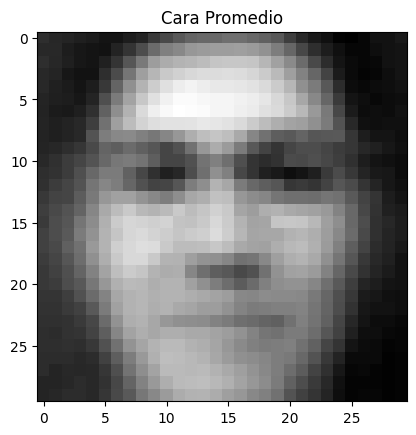

In [11]:
# Cara promedio
cara_promedio = pca.mean_.reshape((30, 30)).astype(np.uint8)
plt.imshow(cara_promedio, cmap='gray')
plt.title('Cara Promedio')
plt.show()

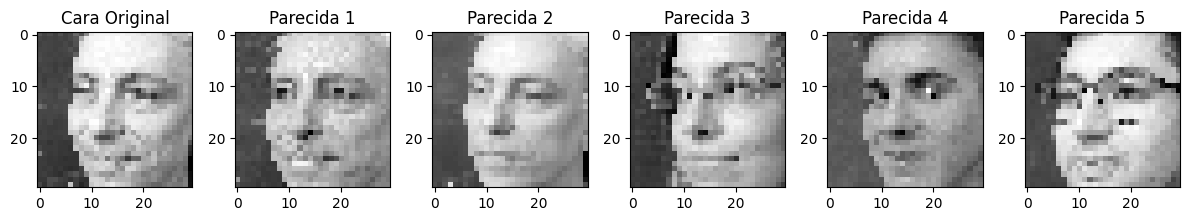

In [15]:
# Caras más parecidas (basado en la distancia euclidiana en el espacio PCA)
def encontrar_mas_parecidas_pca(indice_referencia, caras_pca, n=5):
    """Encuentra las n caras más parecidas a una cara de referencia en el espacio PCA."""
    from sklearn.metrics.pairwise import euclidean_distances
    distancias = euclidean_distances(caras_pca[indice_referencia].reshape(1, -1), caras_pca)[0]
    indices_ordenados = np.argsort(distancias)[1:n+1] # Excluye la propia cara
    return indices_ordenados

if caras_pca.shape[0] > 5:
    indices_parecidas = encontrar_mas_parecidas_pca(0, caras_pca)
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(caras_recortadas[0].reshape((30, 30)), cmap='gray')
    plt.title('Cara Original')
    for i, indice in enumerate(indices_parecidas):
        plt.subplot(1, 6, i + 2)
        plt.imshow(caras_recortadas[indice].reshape((30, 30)), cmap='gray')
        plt.title(f'Parecida {i+1}')
    plt.tight_layout()
    plt.show()

Número mínimo de componentes PCA para el 95% de varianza: 137


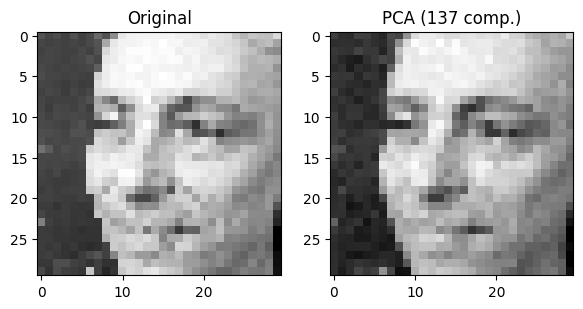

In [16]:
# Cantidad mínima de componentes principales para reconstrucción
def encontrar_n_componentes_pca(varianza_deseada=0.95):
    """Encuentra el número mínimo de componentes para explicar la varianza deseada."""
    pca_temp = PCA(n_components=None)
    pca_temp.fit(caras_recortadas)
    varianza_acumulada = np.cumsum(pca_temp.explained_variance_ratio_)
    n_componentes = np.argmax(varianza_acumulada >= varianza_deseada) + 1
    return n_componentes

n_componentes_minimos = encontrar_n_componentes_pca(0.95)
print(f"Número mínimo de componentes PCA para el 95% de varianza: {n_componentes_minimos}")

pca_reconstruccion = PCA(n_components=n_componentes_minimos)
caras_pca_reconstruccion = pca_reconstruccion.fit_transform(caras_recortadas)
cara_reconstruida = pca_reconstruccion.inverse_transform(caras_pca_reconstruccion[0]).reshape((30, 30)).astype(np.uint8)

if caras_recortadas.shape[0] > 0:
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(caras_recortadas[0].reshape((30, 30)), cmap='gray')
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(cara_reconstruida, cmap='gray')
    plt.title(f'PCA ({n_componentes_minimos} comp.)')
    plt.tight_layout()
    plt.show()


Recorte de Caras con MediaPipe

In [17]:
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [21]:
import mediapipe as mp
import time

In [27]:
# 2- Curado de las imágenes: recortar las caras de las fotos (CON MEDIAPIPE)
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

def recortar_cara_mediapipe(ruta_imagen, tamaño=(60, 60)):
    """Detecta y recorta la primera cara encontrada en una imagen usando MediaPipe."""
    try:
        with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
            img = cv2.imread(ruta_imagen)
            if img is None:
                print(f"Error al leer la imagen: {ruta_imagen}")
                return None
            # Convert the BGR image to RGB before processing.
            results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            if results.detections:
                for detection in results.detections:
                    bboxC = detection.location_data.relative_bounding_box
                    ih, iw, _ = img.shape
                    bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                           int(bboxC.width * iw), int(bboxC.height * ih)

                    # Recortar la cara con un pequeño margen
                    margin_percent = 0.1
                    x, y, w, h = bbox
                    margin_x = int(w * margin_percent)
                    margin_y = int(h * margin_percent)
                    x1 = max(0, x - margin_x)
                    y1 = max(0, y - margin_y)
                    x2 = min(iw, x + w + margin_x)
                    y2 = min(ih, y + h + margin_y)

                    cara_recortada = cv2.resize(cv2.cvtColor(img[y1:y2, x1:x2], cv2.COLOR_BGR2GRAY), tamaño)
                    return cara_recortada.flatten() # Aplanar la imagen para PCA/ISOMAP
                # Si se detectaron caras pero no se retornó ninguna (por ejemplo, error en el bucle),
                # podríamos retornar None o manejarlo de otra manera. Por ahora, retornamos None.
                return None
            else:
                print(f"No se encontraron caras en: {ruta_imagen}")
                return None
    except Exception as e:
        print(f"Error al procesar {ruta_imagen}: {e}")
        return None

start_time = time.time()
caras_recortadas = []
etiquetas_recortadas = []
for ruta, etiqueta in zip(rutas_imagenes, etiquetas):
    cara = recortar_cara_mediapipe(ruta)
    if cara is not None:
        caras_recortadas.append(cara)
        etiquetas_recortadas.append(etiqueta)

end_time = time.time()
print(f"Tiempo de curado de imágenes (MediaPipe): {end_time - start_time:.2f} segundos")

caras_recortadas = np.array(caras_recortadas)
etiquetas_recortadas = np.array(etiquetas_recortadas)
print(f"Se recortaron {caras_recortadas.shape[0]} caras de tamaño 30x30.")


No se encontraron caras en: /content/drive/MyDrive/DMA/Eigenfaces/Mauricio/IMG_0207[1].jpg
Tiempo de curado de imágenes (MediaPipe): 111.39 segundos
Se recortaron 335 caras de tamaño 30x30.


In [28]:
n_componentes_pca = min(100, caras_recortadas.shape[1]) # Un número razonable, ajustar según necesidad
pca = PCA(n_components=n_componentes_pca)
caras_pca = pca.fit_transform(caras_recortadas)


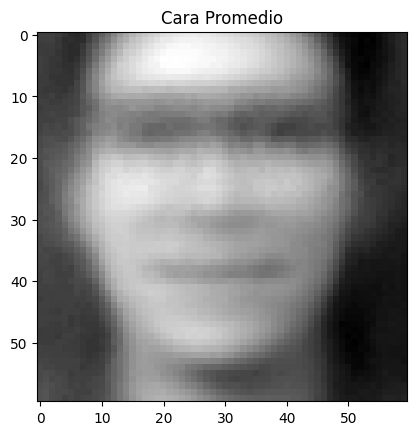

In [29]:
# Cara promedio
cara_promedio = pca.mean_.reshape((60, 60)).astype(np.uint8)
plt.imshow(cara_promedio, cmap='gray')
plt.title('Cara Promedio')
plt.show()

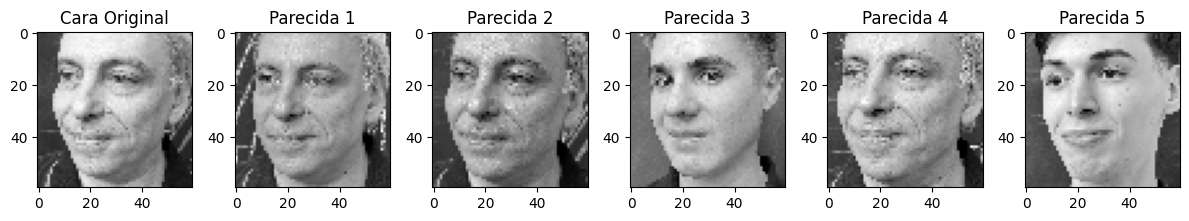

In [31]:
# Caras más parecidas (basado en la distancia euclidiana en el espacio PCA)
def encontrar_mas_parecidas_pca(indice_referencia, caras_pca, n=5):
    """Encuentra las n caras más parecidas a una cara de referencia en el espacio PCA."""
    from sklearn.metrics.pairwise import euclidean_distances
    distancias = euclidean_distances(caras_pca[indice_referencia].reshape(1, -1), caras_pca)[0]
    indices_ordenados = np.argsort(distancias)[1:n+1] # Excluye la propia cara
    return indices_ordenados

if caras_pca.shape[0] > 5:
    indices_parecidas = encontrar_mas_parecidas_pca(0, caras_pca)
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(caras_recortadas[0].reshape((60, 60)), cmap='gray')
    plt.title('Cara Original')
    for i, indice in enumerate(indices_parecidas):
        plt.subplot(1, 6, i + 2)
        plt.imshow(caras_recortadas[indice].reshape((60, 60)), cmap='gray')
        plt.title(f'Parecida {i+1}')
    plt.tight_layout()
    plt.show()

Número mínimo de componentes PCA para el 95% de varianza: 138


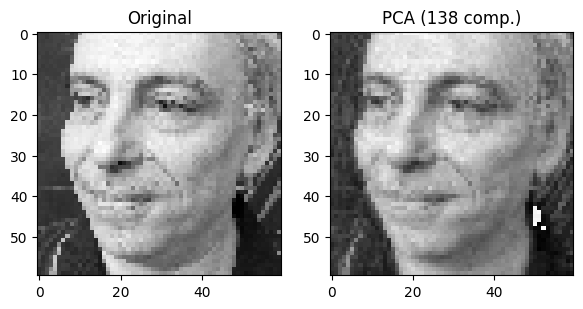

In [36]:
# Cantidad mínima de componentes principales para reconstrucción
def encontrar_n_componentes_pca(varianza_deseada=0.9):
    """Encuentra el número mínimo de componentes para explicar la varianza deseada."""
    pca_temp = PCA(n_components=None)
    pca_temp.fit(caras_recortadas)
    varianza_acumulada = np.cumsum(pca_temp.explained_variance_ratio_)
    n_componentes = np.argmax(varianza_acumulada >= varianza_deseada) + 1
    return n_componentes

n_componentes_minimos = encontrar_n_componentes_pca(0.9)
print(f"Número mínimo de componentes PCA para el 95% de varianza: {n_componentes_minimos}")

pca_reconstruccion = PCA(n_components=n_componentes_minimos)
caras_pca_reconstruccion = pca_reconstruccion.fit_transform(caras_recortadas)
cara_reconstruida = pca_reconstruccion.inverse_transform(caras_pca_reconstruccion[0]).reshape((60, 60)).astype(np.uint8)

if caras_recortadas.shape[0] > 0:
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(caras_recortadas[0].reshape((60, 60)), cmap='gray')
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(cara_reconstruida, cmap='gray')
    plt.title(f'PCA ({n_componentes_minimos} comp.)')
    plt.tight_layout()
    plt.show()

In [ ]:
# 5- Reducción de la dimensionalidad (con ISOMAP)
# Cómo se eligen las dimensiones mínimas con ISOMAP:
# No hay una regla fija como la varianza explicada en PCA.
# Generalmente, se experimenta con diferentes números de componentes y se evalúa la calidad de la representación.
# Métodos comunes:
#   - Visualización: Graficar los datos reducidos en 2D o 3D y observar si los grupos se mantienen separados.
#   - Métricas de calidad: Evaluar la "stress" o el error de reconstrucción del embedding ISOMAP. Un valor bajo indica una mejor representación.
#   - Tareas posteriores: Evaluar el rendimiento del embedding en la tarea para la que se está utilizando (ej., clasificación).

n_vecinos_isomap = 5 # Parámetro a ajustar
n_componentes_isomap = 2 # Inicialmente probar con 2 para visualización

if caras_recortadas.shape[0] > n_vecinos_isomap:
    isomap = Isomap(n_neighbors=n_vecinos_isomap, n_components=n_componentes_isomap)
    caras_isomap = isomap.fit_transform(caras_recortadas)
    print(f"Forma de las caras con ISOMAP ({n_componentes_isomap} componentes): {caras_isomap.shape}")

    # Visualización (si n_componentes_isomap = 2)
    if n_componentes_isomap == 2 and len(nombres_archivos) == caras_isomap.shape[0]:
        # Crear etiquetas simples basadas en los nombres de archivo (puedes mejorarlo)
        etiquetas = [nombre.split('_')[0] if '_' in nombre else 'desconocido' for nombre in nombres_archivos]
        le = LabelEncoder()
        etiquetas_numericas = le.fit_transform(etiquetas)

        plt.scatter(caras_isomap[:, 0], caras_isomap[:, 1], c=etiquetas_numericas, cmap='viridis')
        plt.colorbar(label='Etiqueta')
        plt.title(f'ISOMAP (n_vecinos={n_vecinos_isomap}, n_componentes={n_componentes_isomap})')
        plt.xlabel('Dimensión 1')
        plt.ylabel('Dimensión 2')
        plt.show()

    # Para elegir el número mínimo de componentes, puedes iterar y evaluar la calidad
    # Aquí un ejemplo conceptual (requiere una métrica de calidad):
    # errores_reconstruccion = []
    # for n_comp in range(2, min(20, caras_recortadas.shape[1])):
    #     isomap_temp = Isomap(n_neighbors=n_vecinos_isomap, n_components=n_comp)
    #     caras_isomap_temp = isomap_temp.fit_transform(caras_recortadas)
    #     # Calcular error de reconstrucción (esto es más complejo para ISOMAP)
    #     # Una aproximación podría ser la varianza explicada de un PCA posterior
    #     pca_interno = PCA(n_components=min(10, n_comp)) # Reducir aún más para estimar varianza
    #     pca_interno.fit(caras_isomap_temp)
    #     errores_reconstruccion.append(1 - np.sum(pca_interno.explained_variance_ratio_))
    #
    # plt.plot(range(2, min(20, caras_recortadas.shape[1])), errores_reconstruccion)
    # plt.xlabel('Número de Componentes ISOMAP')
    # plt.ylabel('Error de Reconstrucción (aproximado)')
    # plt.title('Evaluación del número de componentes ISOMAP')
    # plt.show()
else:
    print("No suficientes datos para aplicar ISOMAP con el número de vecinos especificado.")

# 6- Armar un dataset con los datos de las imágenes + las etiquetas
# Asumiendo que los nombres de los archivos contienen alguna información de la etiqueta.
# Esto dependerá de cómo estén nombrados tus archivos.

datos = []
etiquetas = []
if len(nombres_archivos) == caras_recortadas.shape[0]:
    for i, nombre in enumerate(nombres_archivos):
        # Ejemplo simple: si el nombre del archivo es "persona1_foto1.jpg", la etiqueta podría ser "persona1"
        etiqueta = nombre.split('_')[0] if '_' in nombre else 'desconocido'
        datos.append(caras_recortadas[i]) # Usando las caras recortadas originales como ejemplo
        etiquetas.append(etiqueta)

datos = np.array(datos)
etiquetas = np.array(etiquetas)

# Dividir en conjuntos de entrenamiento y prueba
if datos.shape[0] > 0:
    X_train, X_test, y_train, y_test = train_test_split(datos, etiquetas, test_size=0.2, random_state=42)
    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
    print(f"Tamaño del conjunto de prueba: {X_test.shape}")
    print(f"Etiquetas de entrenamiento: {np.unique(y_train)}")
else:
    print("No hay datos suficientes para crear el dataset.")

# También puedes crear datasets con las representaciones de PCA o ISOMAP
if caras_pca.shape[0] > 0 and len(etiquetas) == caras_pca.shape[0]:
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(caras_pca, etiquetas, test_size=0.2, random_state=42)
    print(f"Tamaño del conjunto de entrenamiento (PCA): {X_train_pca.shape}")

if hasattr(isomap, 'embedding_') and len(etiquetas) == isomap.embedding_.shape[0]:
    X_train_isomap, X_test_isomap, y_train_isomap, y_test_isomap = train_test_split(isomap.embedding_, etiquetas, test_size=0.2, random_state=42)
    print(f"Tamaño del conjunto de entrenamiento (ISOMAP): {X_train_isomap.shape}")

In [ ]:
# 7- Pasar por la red neuronal que está en github
# Necesitarás la URL del repositorio de GitHub y entender cómo usar la red neuronal.
# Esto generalmente implica:
#   1. Clonar el repositorio en Colab.
#   2. Cargar los pesos pre-entrenados (si los hay).
#   3. Adaptar la entrada de la red neuronal al formato de tus datos (X_train, X_test, etc.).
#   4. Entrenar la red (si es necesario) o realizar inferencia.

# Ejemplo conceptual (deberás adaptarlo al repositorio específico):
# !git clone <URL_DEL_REPOSITORIO>
# import sys
# sys.path.append('/content/<nombre_del_repositorio>') # Añadir al path de Python

# from <modulo_de_la_red> import <clase_de_la_red>

# # Cargar el modelo
# modelo = <clase_de_la_red>(input_shape=X_train.shape[1], num_classes=len(np.unique(y_train)))
# # ... cargar pesos si es necesario ...

# # Entrenar el modelo
# # modelo.fit(X_train, y_train, ...)

# # Evaluar el modelo
# # loss, accuracy = modelo.evaluate(X_test, y_test)
# # print(f'Loss: {loss}, Accuracy: {accuracy}')

print("\n¡Programa completado hasta la preparación del dataset para la red neuronal!")
print("Recuerda adaptar el paso 7 con la información de tu repositorio de GitHub.")